# Conceptular Synthesis Experiment 1: Resynthesis of a snare drum sample

In [14]:
%pylab inline
from IPython.display import Audio
import librosa
import scipy as sp
figsize(20,6)

Populating the interactive namespace from numpy and matplotlib


In [36]:

def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = max(abs(np.linalg.eig(internalWeights)[0]))
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

pLoop = lambda n,p: p[n%p.size]

In [37]:
y, sr = librosa.load("audios/snare.wav", sr=22050)
y = y[20:]
windowSize =15
padding = windowSize - (y.size % windowSize)
y = np.concatenate((y, np.zeros(padding)))
nWindows = int(y.size/windowSize)
print(y.shape, nWindows)

(3300,) 220


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


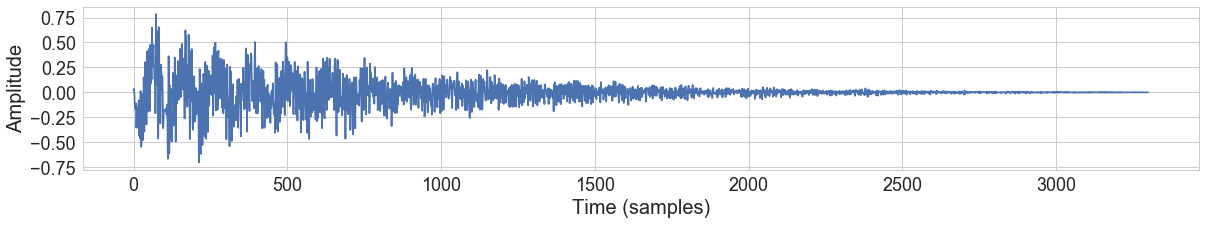

In [38]:
import seaborn as sns
sns.set(style="whitegrid")
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

plot(y)
figsize(20,4)
plt.savefig('/tmp/snare.eps',bbox_inches='tight')


In [39]:
Audio(data=y[:],rate=sr)

In [40]:
#divide out windows
patterns = np.zeros((nWindows, windowSize))
for i in range(nWindows):
    patterns[i] = y[i*windowSize : (i+1) * windowSize]

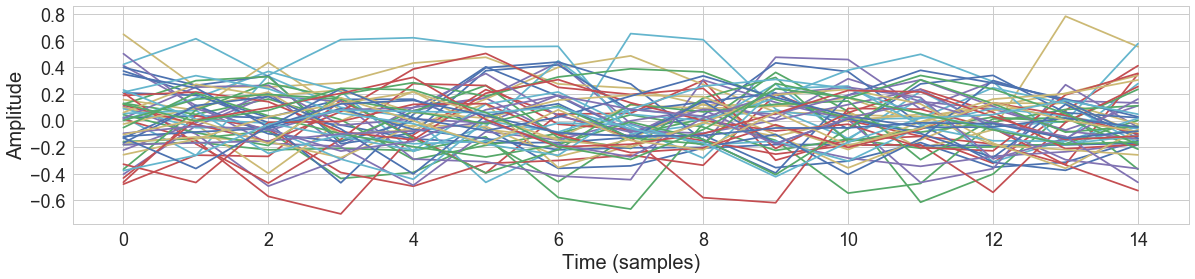

In [41]:
figsize(20,4)
for i in range(int(50)):
    plot(patterns[i])
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)    
plt.savefig('/tmp/snarePieces.eps',bbox_inches='tight')    

In [42]:
%%time
#create a random reservoir and load it with patterns using Jaeger's method
def makeLoadedNetwork_v2(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
#     xCollector = np.zeros((p['N'], p['learnLength']))
#     pCollector = np.zeros((1, p['learnLength']))
    x = np.zeros((p['N'],1))
    
#     allTrainxArgs = np.zeros((p['N'] + 1, 0));
    allTrainxArgs = np.zeros((p['N'] + 1, p['learnLength'] * p['patts'].shape[0]));
#     allTrainOldxArgs = np.zeros((p['N'], 0));
    allTrainOldxArgs = np.zeros((p['N'], p['learnLength'] * p['patts'].shape[0]));
#     allTrainWtargets = np.zeros((p['N'], 0));
    allTrainWtargets = np.zeros((p['N'], p['learnLength'] * p['patts'].shape[0]));
#     allTrainOuts = np.zeros((1, 0));
    allTrainOuts = np.zeros((1, p['learnLength'] * p['patts'].shape[0]));
    patternRs =  np.zeros((1, p['patts'].shape[0]), dtype=np.object)
    print('Loading patterns: ', end='')
    for i_pattern in range(p['patts'].shape[0]):
        print(i_pattern, " ", end='')
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
        xOldCollector = np.zeros((p['N'], p['learnLength']));
        WTargetCollector = np.zeros((p['N'], p['learnLength']));
        pCollector = np.zeros((1, p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt.take(n, mode='wrap')
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        storeBegin = i_pattern * p['learnLength']
        storeEnd = (i_pattern * p['learnLength']) + p['learnLength']
        patternRs[0,i_pattern] = R
#         allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
        allTrainxArgs[:,storeBegin : storeEnd ] = xCollector
#         allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
        allTrainOldxArgs[:,storeBegin : storeEnd ] = xOldCollector
#         allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
        allTrainOuts[:,storeBegin : storeEnd ] = pCollector
#         allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)
        allTrainWtargets[:,storeBegin : storeEnd ]  = WTargetCollector


    Wout = (linalg.inv(allTrainxArgs.dot(allTrainxArgs.conj().T) +
                      (p['TychonovAlphaReadout'] * np.eye(p['N'] + 1))).dot(allTrainxArgs).dot(allTrainOuts.conj().T)).conj().T

    outsRecovered = Wout.dot(allTrainxArgs);
    NRMSE_readout = mean(nrmse(outsRecovered, allTrainOuts))
    absSize_readout = mean(mean(abs(Wout), axis=0))
    print("\nNRMSE readout: ", NRMSE_readout, " :: ", end='')
    print("absSize readout: ", absSize_readout)
    
    W = (linalg.inv(allTrainOldxArgs.dot(allTrainOldxArgs.conj().T) +
                      (p['TychonovAlpha'] * np.eye(p['N']))).dot(allTrainOldxArgs).dot(allTrainWtargets.conj().T)).conj().T
    NRMSE_W = mean(nrmse(W.dot(allTrainOldxArgs), allTrainWtargets))
    absSize_W = mean(mean(abs(W), axis=0))
    print("NRMSE W: ", NRMSE_W, " :: ", end='')
    print("absSize W: ", absSize_W)

    data ={k: v for k, v in locals().items() if k in 
           ('p','Win','Wstar', 'Wbias','NRMSE_W', 'absSize_W','patternRs','W',
            'Wout', 'allTrainOldxArgs','NRMSE_readout', 'absSize_readout')}
    return data

    


    
params = {'N':900, 'NetSR':1.5, 'NetinpScaling':1.2,'BiasScaling':0.5,'TychonovAlpha':0.0001,
         'washoutLength':windowSize*4, 'learnLength':windowSize * 4, 'TychonovAlphaReadout':0.001,
          'LR': 0.99,
           'patts':patterns[np.arange(int(1500/15.0))]
#           'patts':patterns
         }



sampleSize = 10
loadedNets = np.zeros(sampleSize, dtype=np.object)
for i_net, net in enumerate(loadedNets):
    print(i_net)
    loadedNets[i_net] = makeLoadedNetwork_v2(params)
nrmses = [x['NRMSE_readout'] for x in loadedNets]
bestNetwork = np.argmin(nrmses)
print("NRMSEs: best: ", loadedNets[bestNetwork]['NRMSE_readout'], "avg: ", np.mean(nrmses) )



0
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  
NRMSE readout:  0.010797652135998752  :: absSize readout:  0.0034611427221179097
NRMSE W:  0.027227884944059595  :: absSize W:  0.029055479425607034
1
Loading patterns: 0  1  2  3  4  5  6  7  8  9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99  
NRMSE readout:  0.02434410825

In [43]:
def computeConceptor(net, i_pattern, alpha):
    print('Computing conceptor, alpha: ', alpha)
    Cs = np.zeros(4, dtype=np.object)
    R = net['patternRs'][0,i_pattern]
    [U,s,V] = svd(R)
    S = diag(s)
    Snew = S.dot(linalg.inv(S + pow(alpha, -2) * np.eye(net['p']['N'])))

    C =  U.dot(Snew).dot(U.T);
    Cs[0] = C
    Cs[1] = U
    Cs[2] = diag(Snew)
    Cs[3] = diag(S)

    return Cs


def testConceptor(net, cs, recallTestLength):
    trials = 1
    attens = np.zeros(trials)
    C = cs[0]
    for i_trial in range(trials):
        x_CTestPL = np.zeros((net['p']['N'], recallTestLength))
        z_CTestPL = np.zeros((net['p']['N'], recallTestLength))
        x = 0.5 * np.random.randn(net['p']['N'],1) * 0.0
        z = x
        for n in range(recallTestLength + net['p']['washoutLength']):
            xOld = x
            Wtarget = (net['W'].dot(x))
            z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
            x = C.dot(z)
            xPrev = x
            if (n > net['p']['washoutLength']):
                x_CTestPL[:,n-net['p']['washoutLength']] = x.T
                z_CTestPL[:,n-net['p']['washoutLength']] = z.T

        attenuation = np.mean(pow(np.linalg.norm(z_CTestPL[:,:] - x_CTestPL[:,:], axis=1),2)) / np.mean(pow(np.linalg.norm(z_CTestPL[:,:], axis=1),2))
        attens[i_trial] = attenuation
        
    return np.mean(attens)



In [44]:
%%time
import scipy
def fitnessf(aperture, *args):
    print('Pattern: ', args[0])
    cs = computeConceptor(loadedNets[bestNetwork], args[0], aperture)
    atten = testConceptor(loadedNets[bestNetwork], cs, windowSize*4)
    return atten

#scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=0.1, args = (0,))
apertures = [scipy.optimize.fminbound(fitnessf, 0,1000,  disp=3, xtol=1, args = (x,)) 
             for x in np.arange(params['patts'].shape[0])]

Pattern:  0
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000407859        initial
Pattern:  0
Computing conceptor, alpha:  618.0339887498948
    2        618.034  0.000409888        golden
Pattern:  0
Computing conceptor, alpha:  236.0679774997897
    3        236.068  0.000403289        golden
Pattern:  0
Computing conceptor, alpha:  145.89803375031545
    4        145.898  0.000394967        golden
Pattern:  0
Computing conceptor, alpha:  90.16994374947424
    5        90.1699    0.0003842        golden
Pattern:  0
Computing conceptor, alpha:  55.72809000084122
    6        55.7281  0.000366655        golden
Pattern:  0
Computing conceptor, alpha:  34.44185374863304
    7        34.4419  0.000329345        golden
Pattern:  0
Computing conceptor, alpha:  21.286236252208198
    8        21.2862  0.000288906        golden
Pattern:  0
Computing conceptor, alpha:  13.155617496424847
    9        13.1556  0.0002

   13        306.582   0.00256848        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  5
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00197411        initial
Pattern:  5
Computing conceptor, alpha:  618.0339887498948
    2        618.034   0.00197765        golden
Pattern:  5
Computing conceptor, alpha:  236.0679774997897
    3        236.068   0.00196588        golden
Pattern:  5
Computing conceptor, alpha:  145.89803375031545
    4        145.898   0.00195059        golden
Pattern:  5
Computing conceptor, alpha:  90.16994374947424
    5        90.1699   0.00194375        golden
Pattern:  5
Computing conceptor, alpha:  55.72809000084122
    6        55.7281   0.00207207        golden
Pattern:  5
Computing conceptor, alpha:  111.45618000168243
    7        111.456    0.0019424        golden
Pattern:  5
Computing conceptor,

    9        981.433   0.00288609        golden
Pattern:  9
Computing conceptor, alpha:  988.5251531511864
   10        988.525   0.00288608        golden
Pattern:  9
Computing conceptor, alpha:  992.9081546317335
   11        992.908   0.00288608        golden
Pattern:  9
Computing conceptor, alpha:  995.6169985194527
   12        995.617   0.00288608        golden
Pattern:  9
Computing conceptor, alpha:  997.2911561122806
   13        997.291   0.00288608        golden
Pattern:  9
Computing conceptor, alpha:  998.325842407172
   14        998.326   0.00288607        golden
Pattern:  9
Computing conceptor, alpha:  998.9653137051085
   15        998.965   0.00288607        golden
Pattern:  9
Computing conceptor, alpha:  999.3605287020633
   16        999.361   0.00288607        golden

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  10
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x

    5        268.082   0.00379148        parabolic
Pattern:  14
Computing conceptor, alpha:  270.81504194085835
    6        270.815   0.00379281        parabolic
Pattern:  14
Computing conceptor, alpha:  263.7472047287231
    7        263.747   0.00379057        parabolic
Pattern:  14
Computing conceptor, alpha:  263.19817644150703
    8        263.198   0.00379056        parabolic
Pattern:  14
Computing conceptor, alpha:  262.86483920431385
    9        262.865   0.00379057        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  15
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00845895        initial
Pattern:  15
Computing conceptor, alpha:  618.0339887498948
    2        618.034   0.00842202        golden
Pattern:  15
Computing conceptor, alpha:  763.9320225002102
    3        763.932   0.00840583        golden
Pattern:  15

    4        792.231   0.00268681        parabolic
Pattern:  19
Computing conceptor, alpha:  871.5916453286864
    5        871.592   0.00268679        golden
Pattern:  19
Computing conceptor, alpha:  920.6392723736768
    6        920.639   0.00268678        golden
Pattern:  19
Computing conceptor, alpha:  950.9523729550095
    7        950.952   0.00268677        golden
Pattern:  19
Computing conceptor, alpha:  969.6868994186673
    8        969.687   0.00268677        golden
Pattern:  19
Computing conceptor, alpha:  981.2654735363421
    9        981.265   0.00268677        golden
Pattern:  19
Computing conceptor, alpha:  988.421425882325
   10        988.421   0.00268676        golden
Pattern:  19
Computing conceptor, alpha:  992.844047654017
   11        992.844   0.00268676        golden
Pattern:  19
Computing conceptor, alpha:  995.5773782283079
   12        995.577   0.00268676        golden
Pattern:  19
Computing conceptor, alpha:  997.266669425709
   13        997.267   0.002

    3        236.068   0.00604111        golden
Pattern:  24
Computing conceptor, alpha:  145.89803375031545
    4        145.898   0.00589395        golden
Pattern:  24
Computing conceptor, alpha:  90.16994374947424
    5        90.1699   0.00567444        golden
Pattern:  24
Computing conceptor, alpha:  55.72809000084122
    6        55.7281   0.00551732        golden
Pattern:  24
Computing conceptor, alpha:  34.44185374863304
    7        34.4419   0.00534071        golden
Pattern:  24
Computing conceptor, alpha:  21.286236252208198
    8        21.2862   0.00374258        golden
Pattern:  24
Computing conceptor, alpha:  13.155617496424847
    9        13.1556   0.00274694        golden
Pattern:  24
Computing conceptor, alpha:  8.130618755783354
   10        8.13062   0.00387845        golden
Pattern:  24
Computing conceptor, alpha:  14.903856847540904
   11        14.9039   0.00267638        parabolic
Pattern:  24
Computing conceptor, alpha:  14.57052329314765
   12        14.5705 

   14        62.2668   0.00185812        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  29
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00113143        initial
Pattern:  29
Computing conceptor, alpha:  618.0339887498948
    2        618.034   0.00113185        golden
Pattern:  29
Computing conceptor, alpha:  236.0679774997897
    3        236.068   0.00113034        golden
Pattern:  29
Computing conceptor, alpha:  145.89803375031545
    4        145.898   0.00112756        golden
Pattern:  29
Computing conceptor, alpha:  90.16994374947424
    5        90.1699   0.00112086        golden
Pattern:  29
Computing conceptor, alpha:  55.72809000084122
    6        55.7281   0.00110696        golden
Pattern:  29
Computing conceptor, alpha:  34.44185374863304
    7        34.4419    0.0010904        golden
Pattern:  29
Computing con

   12        38.4847   0.00121903        parabolic
Pattern:  33
Computing conceptor, alpha:  38.15137216529058
   13        38.1514   0.00121905        parabolic
Pattern:  33
Computing conceptor, alpha:  38.81803997359812
   14         38.818   0.00121903        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  34
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00232404        initial
Pattern:  34
Computing conceptor, alpha:  618.0339887498948
    2        618.034   0.00232462        golden
Pattern:  34
Computing conceptor, alpha:  236.0679774997897
    3        236.068   0.00232254        golden
Pattern:  34
Computing conceptor, alpha:  145.89803375031545
    4        145.898   0.00231863        golden
Pattern:  34
Computing conceptor, alpha:  90.16994374947424
    5        90.1699   0.00230871        golden
Pattern:  34
Computi

    9        47.5975  0.000782668        golden
Pattern:  38
Computing conceptor, alpha:  56.763052261536686
   10        56.7631  0.000781765        parabolic
Pattern:  38
Computing conceptor, alpha:  54.909719328097204
   11        54.9097  0.000781695        parabolic
Pattern:  38
Computing conceptor, alpha:  52.116689094547446
   12        52.1167  0.000781779        golden
Pattern:  38
Computing conceptor, alpha:  54.28057277799076
   13        54.2806  0.000781691        parabolic
Pattern:  38
Computing conceptor, alpha:  53.94723863954643
   14        53.9472  0.000781694        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  39
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000851434        initial
Pattern:  39
Computing conceptor, alpha:  618.0339887498948
    2        618.034  0.000852924        golden
Pattern:  39
Co

    5        871.273  0.000893892        golden
Pattern:  43
Computing conceptor, alpha:  920.4426136931157
    6        920.443   0.00089388        golden
Pattern:  43
Computing conceptor, alpha:  950.8308312062401
    7        950.831  0.000893874        golden
Pattern:  43
Computing conceptor, alpha:  969.6117824868757
    8        969.612   0.00089387        golden
Pattern:  43
Computing conceptor, alpha:  981.2190487193643
    9        981.219  0.000893868        golden
Pattern:  43
Computing conceptor, alpha:  988.3927337675112
   10        988.393  0.000893866        golden
Pattern:  43
Computing conceptor, alpha:  992.826314951853
   11        992.826  0.000893865        golden
Pattern:  43
Computing conceptor, alpha:  995.5664188156582
   12        995.566  0.000893865        golden
Pattern:  43
Computing conceptor, alpha:  997.2598961361947
   13         997.26  0.000893865        golden
Pattern:  43
Computing conceptor, alpha:  998.3065226794635
   14        998.307  0.00089

   15        19.2468  0.000778614        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  48
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000802569        initial
Pattern:  48
Computing conceptor, alpha:  618.0339887498948
    2        618.034  0.000802583        golden
Pattern:  48
Computing conceptor, alpha:  236.0679774997897
    3        236.068  0.000802536        golden
Pattern:  48
Computing conceptor, alpha:  145.89803375031545
    4        145.898  0.000802461        golden
Pattern:  48
Computing conceptor, alpha:  90.16994374947424
    5        90.1699  0.000802355        golden
Pattern:  48
Computing conceptor, alpha:  55.72809000084122
    6        55.7281   0.00080261        golden
Pattern:  48
Computing conceptor, alpha:  111.45618000168243
    7        111.456  0.000802399        golden
Pattern:  48
Computing co

   11        17.1683  0.000778273        parabolic
Pattern:  52
Computing conceptor, alpha:  15.296619954436345
   12        15.2966  0.000778447        parabolic
Pattern:  52
Computing conceptor, alpha:  16.453367033936946
   13        16.4534  0.000778029        golden
Pattern:  52
Computing conceptor, alpha:  16.12003345656074
   14          16.12  0.000778033        parabolic
Pattern:  52
Computing conceptor, alpha:  16.78670061131315
   15        16.7867  0.000778104        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  53
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000563875        initial
Pattern:  53
Computing conceptor, alpha:  618.0339887498948
    2        618.034   0.00056396        golden
Pattern:  53
Computing conceptor, alpha:  236.0679774997897
    3        236.068  0.000563654        golden
Pattern:  53
Com

    2        618.034  0.000421219        golden
Pattern:  57
Computing conceptor, alpha:  236.0679774997897
    3        236.068  0.000420801        golden
Pattern:  57
Computing conceptor, alpha:  145.89803375031545
    4        145.898  0.000420023        golden
Pattern:  57
Computing conceptor, alpha:  90.16994374947424
    5        90.1699  0.000418072        golden
Pattern:  57
Computing conceptor, alpha:  55.72809000084122
    6        55.7281  0.000413497        golden
Pattern:  57
Computing conceptor, alpha:  34.44185374863304
    7        34.4419   0.00040447        golden
Pattern:  57
Computing conceptor, alpha:  21.286236252208198
    8        21.2862   0.00039378        golden
Pattern:  57
Computing conceptor, alpha:  13.155617496424847
    9        13.1556  0.000400385        golden
Pattern:  57
Computing conceptor, alpha:  22.541683603466943
   10        22.5417  0.000394699        parabolic
Pattern:  57
Computing conceptor, alpha:  19.689540959185546
   11        19.6895

   11        18.1806   0.00077241        golden
Pattern:  61
Computing conceptor, alpha:  20.452678264722586
   12        20.4527  0.000771957        parabolic
Pattern:  61
Computing conceptor, alpha:  20.119344628027008
   13        20.1193  0.000771934        parabolic
Pattern:  61
Computing conceptor, alpha:  19.786010996275568
   14         19.786  0.000771936        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  62
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000465967        initial
Pattern:  62
Computing conceptor, alpha:  618.0339887498948
    2        618.034  0.000465984        golden
Pattern:  62
Computing conceptor, alpha:  236.0679774997897
    3        236.068  0.000465922        golden
Pattern:  62
Computing conceptor, alpha:  145.89803375031545
    4        145.898  0.000465812        golden
Pattern:  62
Comp

    5        90.1699  0.000629192        golden
Pattern:  66
Computing conceptor, alpha:  55.72809000084122
    6        55.7281  0.000622865        golden
Pattern:  66
Computing conceptor, alpha:  34.44185374863304
    7        34.4419  0.000611227        golden
Pattern:  66
Computing conceptor, alpha:  21.286236252208198
    8        21.2862  0.000599859        golden
Pattern:  66
Computing conceptor, alpha:  13.155617496424847
    9        13.1556  0.000619842        golden
Pattern:  66
Computing conceptor, alpha:  25.09536507616373
   10        25.0954  0.000602523        parabolic
Pattern:  66
Computing conceptor, alpha:  18.18061623706634
   11        18.1806  0.000600492        golden
Pattern:  66
Computing conceptor, alpha:  20.51385884670973
   12        20.5139  0.000599658        parabolic
Pattern:  66
Computing conceptor, alpha:  20.1805252091067
   13        20.1805   0.00059963        parabolic
Pattern:  66
Computing conceptor, alpha:  19.847191576447806
   14        19.8

   15        15.3316  0.000417862        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  71
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000468806        initial
Pattern:  71
Computing conceptor, alpha:  618.0339887498948
    2        618.034  0.000468833        golden
Pattern:  71
Computing conceptor, alpha:  236.0679774997897
    3        236.068  0.000468736        golden
Pattern:  71
Computing conceptor, alpha:  145.89803375031545
    4        145.898  0.000468559        golden
Pattern:  71
Computing conceptor, alpha:  90.16994374947424
    5        90.1699  0.000468146        golden
Pattern:  71
Computing conceptor, alpha:  55.72809000084122
    6        55.7281  0.000467368        golden
Pattern:  71
Computing conceptor, alpha:  34.44185374863304
    7        34.4419  0.000466951        golden
Pattern:  71
Computing con

   11        30.8537  0.000435712        golden
Pattern:  75
Computing conceptor, alpha:  36.095865117745134
   12        36.0959  0.000435068        parabolic
Pattern:  75
Computing conceptor, alpha:  35.07445036460073
   13        35.0745  0.000435034        parabolic
Pattern:  75
Computing conceptor, alpha:  35.40778421817223
   14        35.4078  0.000435039        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  76
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00155114        initial
Pattern:  76
Computing conceptor, alpha:  618.0339887498948
    2        618.034    0.0015522        golden
Pattern:  76
Computing conceptor, alpha:  236.0679774997897
    3        236.068   0.00154838        golden
Pattern:  76
Computing conceptor, alpha:  145.89803375031545
    4        145.898   0.00154123        golden
Pattern:  76
Comput

    7        34.4419  0.000278094        golden
Pattern:  80
Computing conceptor, alpha:  21.286236252208198
    8        21.2862  0.000256202        golden
Pattern:  80
Computing conceptor, alpha:  13.155617496424847
    9        13.1556  0.000253788        golden
Pattern:  80
Computing conceptor, alpha:  14.909737198987491
   10        14.9097  0.000251346        parabolic
Pattern:  80
Computing conceptor, alpha:  16.660401741324097
   11        16.6604  0.000251106        parabolic
Pattern:  80
Computing conceptor, alpha:  15.977249790814517
   12        15.9772  0.000250992        parabolic
Pattern:  80
Computing conceptor, alpha:  15.643916220500271
   13        15.6439  0.000251028        parabolic
Pattern:  80
Computing conceptor, alpha:  16.31058336112876
   14        16.3106  0.000251018        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  81
Computing conceptor, alpha:  381.9660112501051
 
 

    2        618.034  0.000286052        golden
Pattern:  85
Computing conceptor, alpha:  236.0679774997897
    3        236.068  0.000285459        golden
Pattern:  85
Computing conceptor, alpha:  145.89803375031545
    4        145.898  0.000284369        golden
Pattern:  85
Computing conceptor, alpha:  90.16994374947424
    5        90.1699  0.000281701        golden
Pattern:  85
Computing conceptor, alpha:  55.72809000084122
    6        55.7281  0.000275819        golden
Pattern:  85
Computing conceptor, alpha:  34.44185374863304
    7        34.4419  0.000265773        golden
Pattern:  85
Computing conceptor, alpha:  21.286236252208198
    8        21.2862  0.000258133        golden
Pattern:  85
Computing conceptor, alpha:  13.155617496424847
    9        13.1556  0.000280418        golden
Pattern:  85
Computing conceptor, alpha:  26.311234992849688
   10        26.3112  0.000260105        golden
Pattern:  85
Computing conceptor, alpha:  15.329049561268523
   11         15.329  0

   14        14.0906  0.000224407        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  90
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966  0.000352538        initial
Pattern:  90
Computing conceptor, alpha:  618.0339887498948
    2        618.034  0.000353136        golden
Pattern:  90
Computing conceptor, alpha:  236.0679774997897
    3        236.068  0.000350989        golden
Pattern:  90
Computing conceptor, alpha:  145.89803375031545
    4        145.898   0.00034705        golden
Pattern:  90
Computing conceptor, alpha:  90.16994374947424
    5        90.1699  0.000337435        golden
Pattern:  90
Computing conceptor, alpha:  55.72809000084122
    6        55.7281  0.000315789        golden
Pattern:  90
Computing conceptor, alpha:  34.44185374863304
    7        34.4419  0.000272904        golden
Pattern:  90
Computing con

    9        13.1556  0.000273213        golden
Pattern:  94
Computing conceptor, alpha:  26.311234992849688
   10        26.3112  0.000253529        golden
Pattern:  94
Computing conceptor, alpha:  22.04990276974082
   11        22.0499  0.000252833        parabolic
Pattern:  94
Computing conceptor, alpha:  23.164858964433286
   12        23.1649   0.00025278        parabolic
Pattern:  94
Computing conceptor, alpha:  22.831525287509567
   13        22.8315  0.000252773        parabolic
Pattern:  94
Computing conceptor, alpha:  22.498191615529986
   14        22.4982  0.000252784        parabolic

Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol =  1 )
Pattern:  95
Computing conceptor, alpha:  381.9660112501051
 
 Func-count     x          f(x)          Procedure
    1        381.966   0.00036505        initial
Pattern:  95
Computing conceptor, alpha:  618.0339887498948
    2        618.034  0.000365347        golden
Pattern:  95
C

    3        236.068  0.000268941        golden
Pattern:  99
Computing conceptor, alpha:  145.89803375031545
    4        145.898  0.000268279        golden
Pattern:  99
Computing conceptor, alpha:  90.16994374947424
    5        90.1699   0.00026675        golden
Pattern:  99
Computing conceptor, alpha:  55.72809000084122
    6        55.7281   0.00026391        golden
Pattern:  99
Computing conceptor, alpha:  34.44185374863304
    7        34.4419  0.000261494        golden
Pattern:  99
Computing conceptor, alpha:  21.286236252208198
    8        21.2862  0.000267696        golden
Pattern:  99
Computing conceptor, alpha:  42.57247250441638
    9        42.5725  0.000262165        golden
Pattern:  99
Computing conceptor, alpha:  29.416855007991547
   10        29.4169  0.000261968        golden
Pattern:  99
Computing conceptor, alpha:  35.43804610784209
   11         35.438  0.000261515        parabolic
Pattern:  99
Computing conceptor, alpha:  34.10851990444446
   12        34.1085  

0
Computing conceptor, alpha:  14.38304808818372
0.3148292133408987
1
Computing conceptor, alpha:  88.7975888111816
0.4429459035257059
2
Computing conceptor, alpha:  999.3970290753839
0.9701168883278559
3
Computing conceptor, alpha:  9.249916286564062
0.5868465586805868
4
Computing conceptor, alpha:  306.9152392385709
0.17475722631351848
5
Computing conceptor, alpha:  101.60947313274717
0.1826106729446474
6
Computing conceptor, alpha:  999.3521218513098
0.3343328232127752
7
Computing conceptor, alpha:  999.4496405172831
0.5705490729008853
8
Computing conceptor, alpha:  999.6002107189987
0.9506215848695492
9
Computing conceptor, alpha:  999.3605287020633
0.35098665244982563
10
Computing conceptor, alpha:  7.724399917720995
0.6697877293822483
11
Computing conceptor, alpha:  67.67041288006983
0.43632786407300705
12
Computing conceptor, alpha:  999.396888022532
0.5570538150066209
13
Computing conceptor, alpha:  8.726395130894485
0.9199385794535009
14
Computing conceptor, alpha:  263.198176

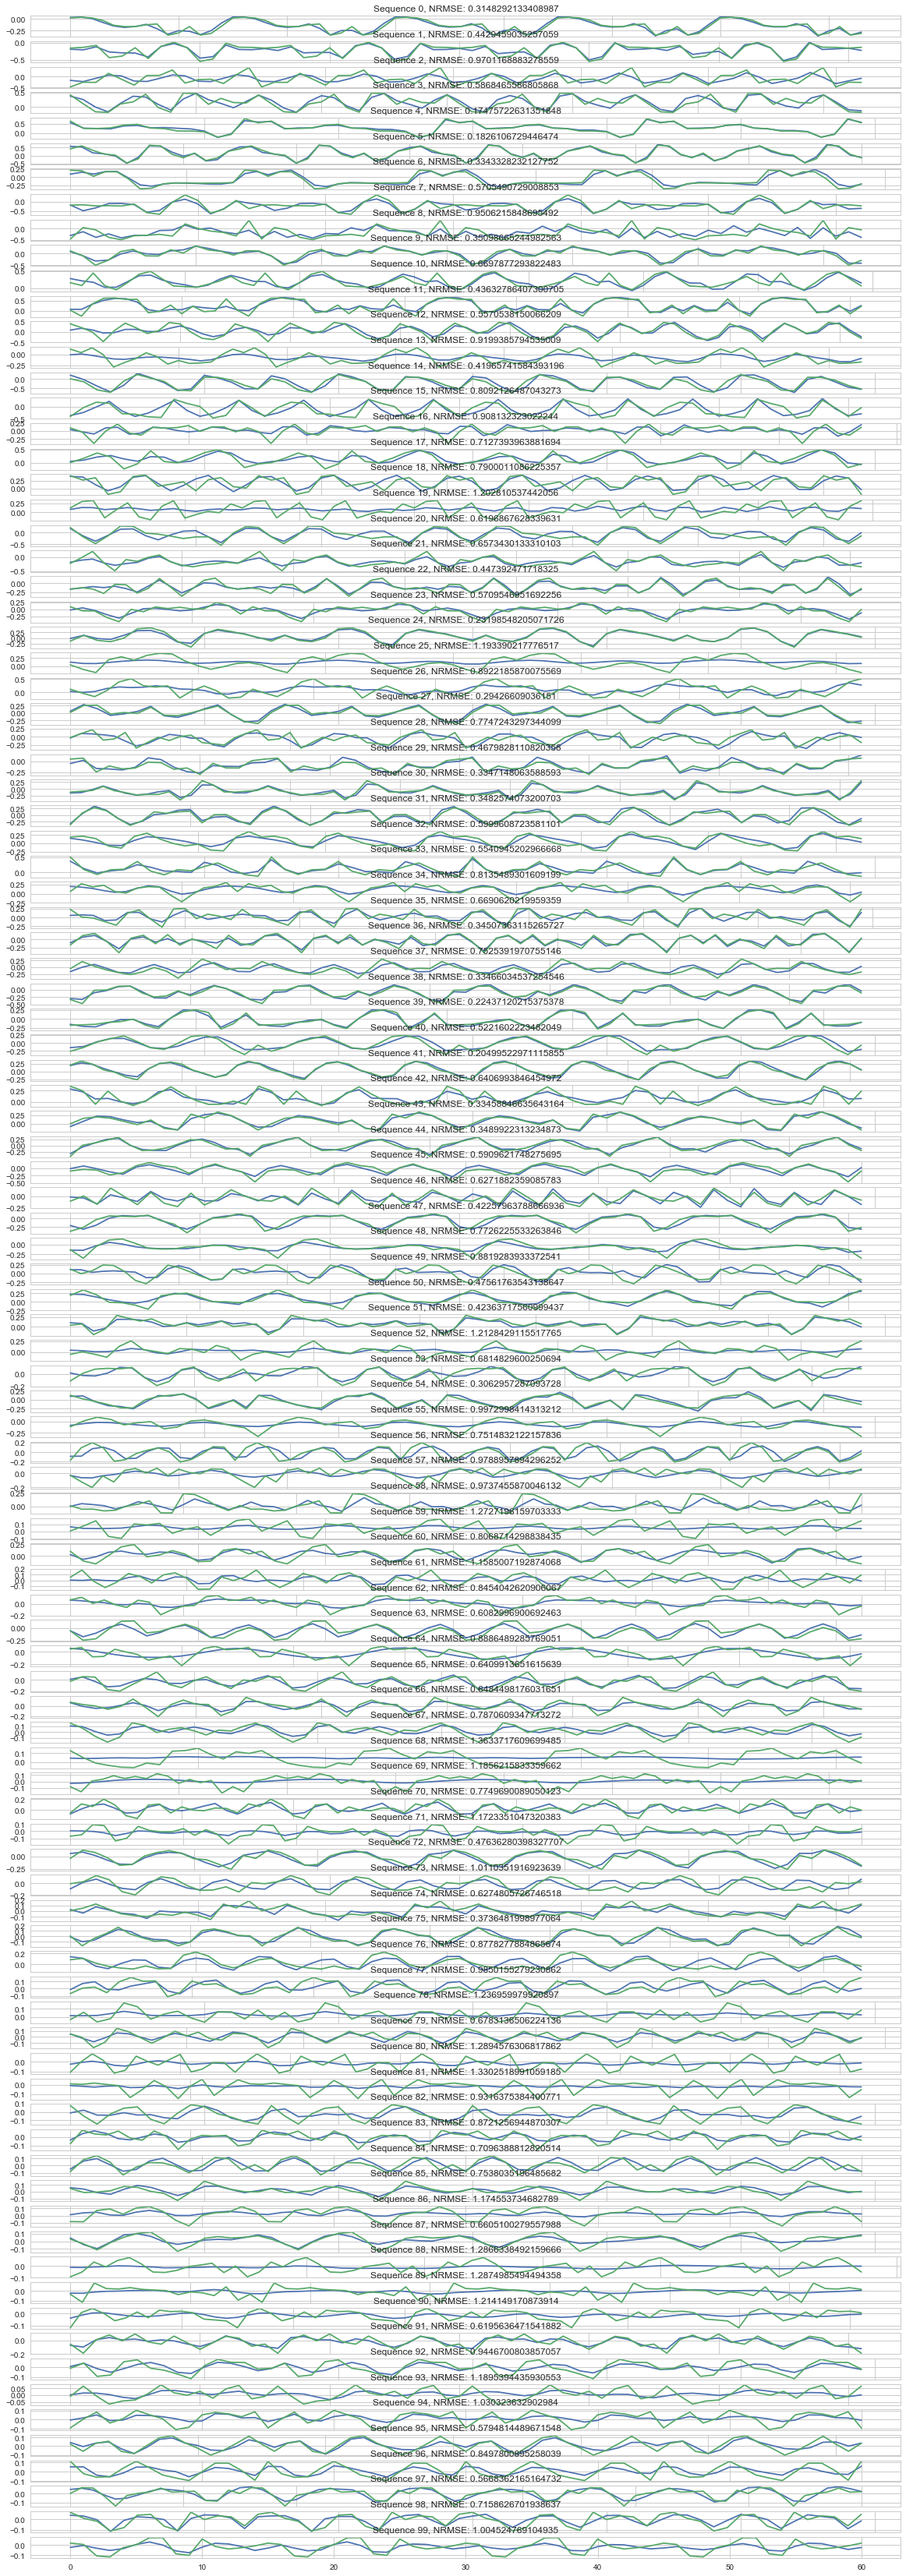

In [50]:
def plotConceptorPattern(net, cs, recallTestLength, i_pattern):
    x_CTestPL = np.zeros((net['p']['N'], recallTestLength, net['p']['patts'].shape[0]))
    z_CTestPL = np.zeros((net['p']['N'], recallTestLength, net['p']['patts'].shape[0]))
    p_CTestPL = np.zeros((1, recallTestLength, net['p']['patts'].shape[0]))
    C = cs[0]
    x = 0.5 * np.random.randn(net['p']['N'],1) * 0
    z = x
    for n in range(recallTestLength + net['p']['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        xPrev = x
        if (n > net['p']['washoutLength']):
            x_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = x.T
            z_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = z.T
            p_CTestPL[:,n-net['p']['washoutLength'],i_pattern] = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
    
#         ax = subplot(subr, p['patts'].shape[0], suboff + i_pattern + 1)
#         ax.set_title("S:" + str(int(suboff/p['patts'].shape[0])) + ", p: " + str(i_pattern) + ", a: " + str(cNet['alphas'][i_pattern]))
#     plot(p_CTestPL[:,:,i_pattern].T)
#     plot([net['p']['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])
    outputPattern = p_CTestPL[:,:,i_pattern][0]
    targetPattern = np.array([net['p']['patts'][i_pattern].take(x, mode='wrap') for x in arange(recallTestLength)])
    templateScan = np.correlate(outputPattern[:net['p']['patts'][i_pattern].size*2],net['p']['patts'][i_pattern])
#     print(templateScan)
    matchPoint = np.argmax(templateScan)
#     print(matchPoint)
    if (matchPoint > 0):
        outputPattern = outputPattern[matchPoint:]
        targetPattern = targetPattern[:-matchPoint]
    score = nrmse(outputPattern, targetPattern) 
    print(score)
    plot(outputPattern)
    plot(targetPattern)
    return score
    
    
figsize(20,60)
patternCs = np.zeros(len(apertures), dtype=np.object)
scores = np.zeros(len(apertures))
for i_patt in range(len(apertures)):
    print(i_patt)
    ax = subplot(len(apertures), 1, i_patt+1)
    patternCs[i_patt] = computeConceptor(loadedNets[bestNetwork], i_patt, apertures[i_patt])
    scores[i_patt] = plotConceptorPattern(loadedNets[bestNetwork], patternCs[i_patt], windowSize * 5, i_patt)
    ax.set_title("Sequence " + str(i_patt) + ", NRMSE: " + str(scores[i_patt]))
plt.savefig("/tmp/tests.pdf")

0.7300923321162119
[0.31482921 0.4429459  0.97011689 0.58684656 0.17475723 0.18261067
 0.33433282 0.57054907 0.95062158 0.35098665 0.66978773 0.43632786
 0.55705382 0.91993858 0.41965742 0.80921265 0.90813232 0.7127394
 0.79000111 1.20281054 0.61968676 0.65734301 0.44739247 0.5709547
 0.23198548 1.19339022 0.89221859 0.29426609 0.77472433 0.46798281
 0.33471481 0.34825741 0.59996087 0.55409452 0.81354893 0.66906202
 0.34507363 0.7525392  0.33466035 0.2243712  0.52216022 0.20499523
 0.64069938 0.33458847 0.34899223 0.59096217 0.62718824 0.42257964
 0.77262255 0.88192839 0.47561764 0.42363718 1.21284291 0.68148296
 0.30629573 0.99729984 0.75148321 0.97889579 0.97374559 1.27271962
 0.80687143 1.15850072 0.84540426 0.60829969 0.88864893 0.64099137
 0.64844982 0.78706093 1.36337176 1.18562158 0.77496901 1.1723351
 0.4763628  1.01103519 0.62748057 0.3736482  0.87782779 0.98501553
 1.23695998 0.67831365 1.28945763 1.3302519  0.93163754 0.87212569
 0.70963888 0.75380352 1.17455373 0.66051003 1

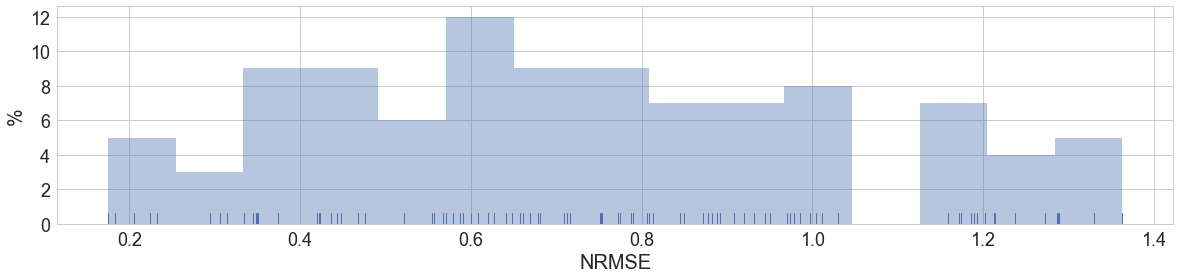

In [78]:
print(np.mean(scores))
print(scores)
figsize(20,4)
plt.xlabel("NRMSE", fontsize=20)
plt.ylabel("%", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

# plot(sort(scores))
print(sort(scores))
# print(median(scores))
sns.distplot(scores, kde=False, rug=True, bins=15)
plt.savefig("/tmp/scoresDistrib.pdf", bbox_inches='tight')

In [32]:
sys.getsizeof(patternCs[0][0]) / 1048576 * 100

617.9916381835938

In [47]:
%%time

def render(net, pcs, lrMod=1.0, cMod=1.0, alphaMod=1.0, speed=1.0, initScale=0.5, initOffset=0.0):
    speed = 1.0/speed
    audio = np.zeros(0)
    x = (initScale * np.random.randn(net['p']['N'],1)) + initOffset
    C = pcs[0][0]
    LR = net['p']['LR'] * lrMod
    orgW = net['W']
    Wmod = orgW * alphaMod
    #run to washout
    for n in range(net['p']['washoutLength']):
        xOld = x
        Wtarget = (net['W'].dot(x))
        z = ((1.0-net['p']['LR']) * xOld) + (net['p']['LR'] * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        
    for n in range(int(windowSize * pcs.shape[0] * abs(speed))):
        currConceptor = int(n/abs(speed) / windowSize)

        if (speed <= 0):
            currConceptor = pcs.shape[0] - currConceptor - 1  #reverse
        C = pcs[currConceptor][0] * cMod
        xOld = x
        Wtarget = (Wmod.dot(x))
        z = ((1.0 - LR) * xOld) + (LR * tanh(Wtarget + net['Wbias']))
        x = C.dot(z)
        newSample = net['Wout'].dot(np.concatenate((x[:,0], np.array([1]))))
        audio = np.concatenate((audio, newSample))
    return audio

# audio = render(loadedNets[bestNetwork], patternCs, 1.0, 1.0, 1, 1.0)


CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 11 µs


In [48]:
patternCs.shape

(100,)

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/output.py:219: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if norm and np.issubdtype(y.dtype, np.float):
/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/util/utils.py:1725: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(x.dtype, float) or np.issubdtype(x.dtype, complex):


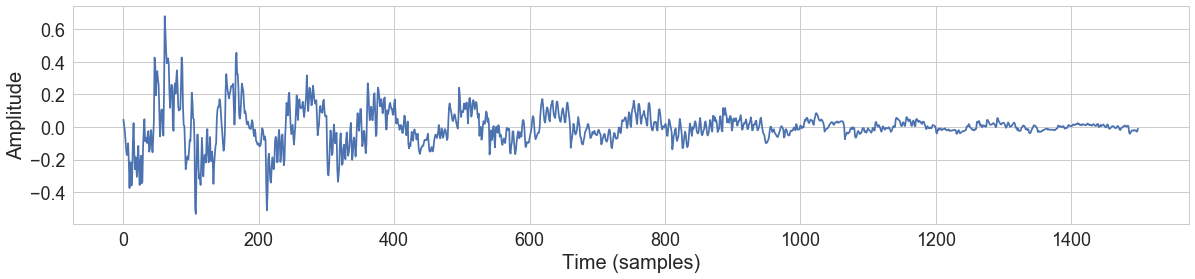

In [99]:

figsize(20,4)
audio = render(loadedNets[bestNetwork], patternCs, 1.0, 1.0, 1, 1.0)
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

plot(audio)
plt.savefig('/tmp/recon.eps', bbox_inches='tight')
Audio(data=audio,rate=sr)
librosa.output.write_wav('/tmp/recon.wav', audio, 22050, norm=True)


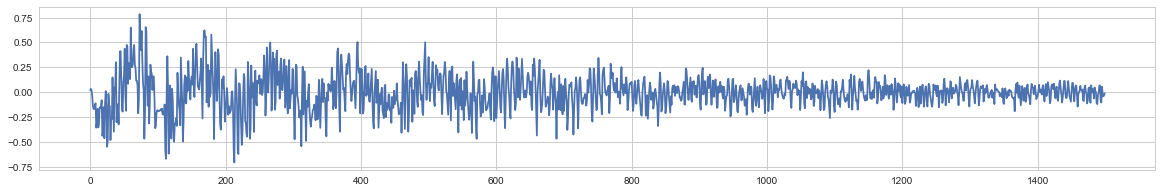

In [30]:
plot(y[:audio.size])
Audio(data=y[:audio.size],rate=sr)


1.1633317648640877


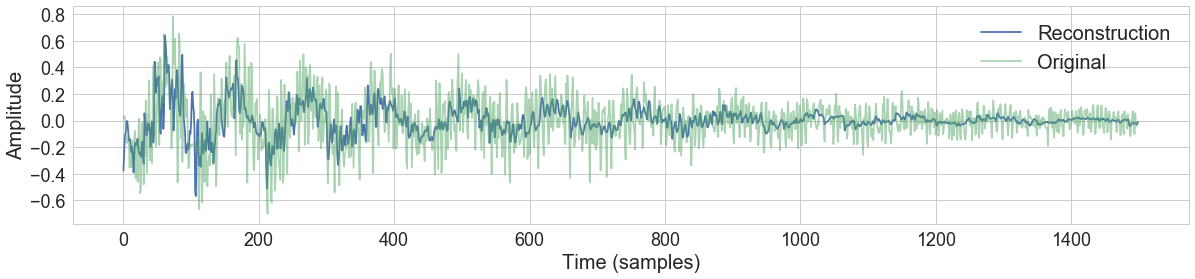

In [77]:
figsize(20,4)
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

plot(audio, alpha=1.0, label='Reconstruction')
plot(y[:audio.size], alpha=0.5, label='Original')
plt.legend(fontsize=20)
plt.savefig("/tmp/reconCompare.pdf", bbox_inches='tight')
print(nrmse(audio, y[:audio.size]))

In [67]:
testCount=500
renderErrors = np.empty(testCount)
renders = np.empty((testCount,audio.size))
for i in range(testCount):
    print(i, end=",")
    audio = render(loadedNets[bestNetwork], patternCs, 1.0, 1.0, 1, 1.0)
    renderErrors[i] = (nrmse(audio, y[:audio.size]))
    renders[i] = audio
#     plot(audio, alpha=0.3)

# plt.savefig("tmp/reconVar.pdf")

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,27

In [213]:
renderErrors.shape

(500,)

1.1564392780666888
0.00575499455772311
1.1636393626866106
1.1483917945472677


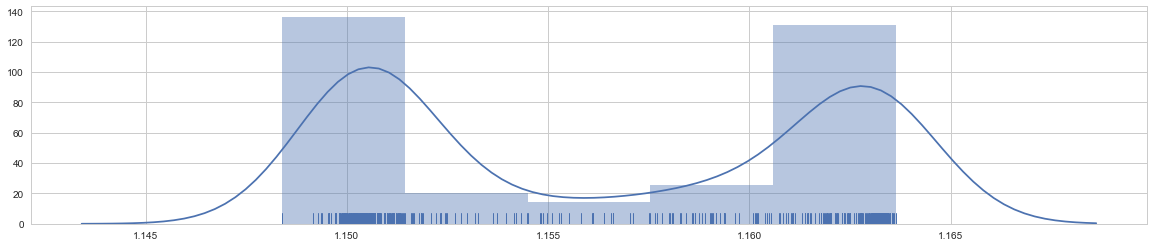

In [68]:
sns.distplot(renderErrors,rug=True)
print(np.mean(renderErrors))
print(np.std(renderErrors))
print(np.max(renderErrors))
print(np.min(renderErrors))


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


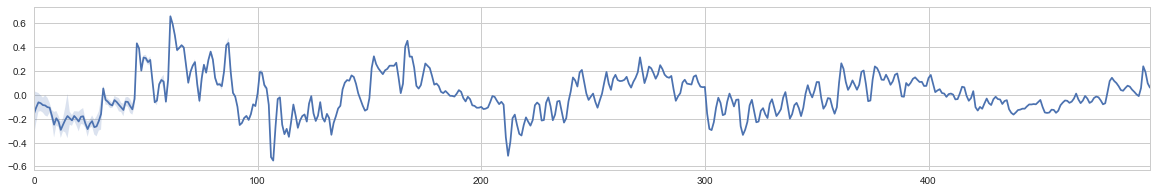

In [69]:
figsize(20,3)
sns.tsplot(renders[:,:500], ci="sd")

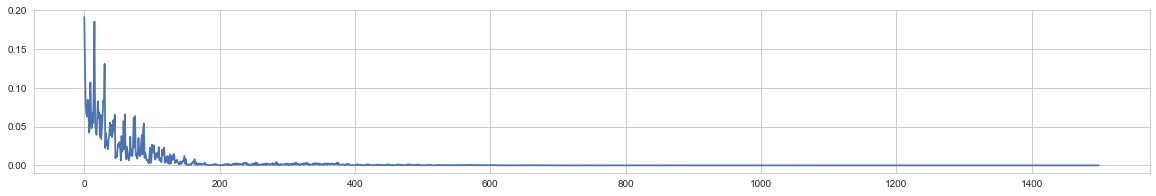

In [70]:

plot(np.std(renders, axis=0))

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


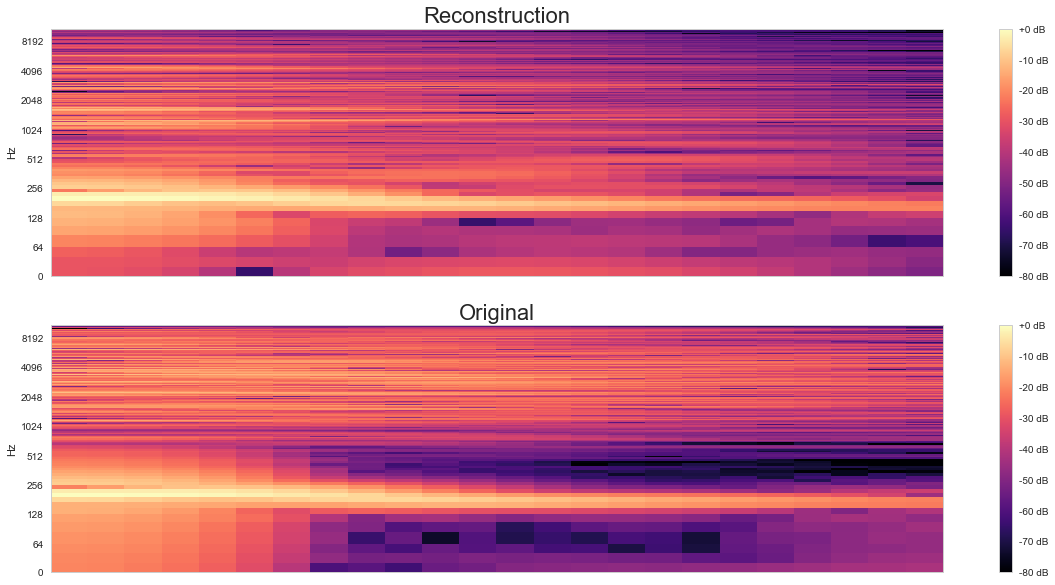

In [80]:
figsize(20,10)
import librosa.display
subplot(2,1,1)
CQT = librosa.amplitude_to_db(librosa.stft(audio, n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Reconstruction', fontsize=22)
subplot(2,1,2)
CQT = librosa.amplitude_to_db(librosa.stft(y[:audio.shape[0]], n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Original', fontsize=22)
plt.savefig("/tmp/expt1Spectra.pdf", bbox_inches='tight')

In [ ]:

figsize(20,3)
audio = render(model['net'], model['Cs'], lrMod=1.0, alphaMod=1.0, speed=1.0)
plot(audio)
Audio(data=audio,rate=sr)

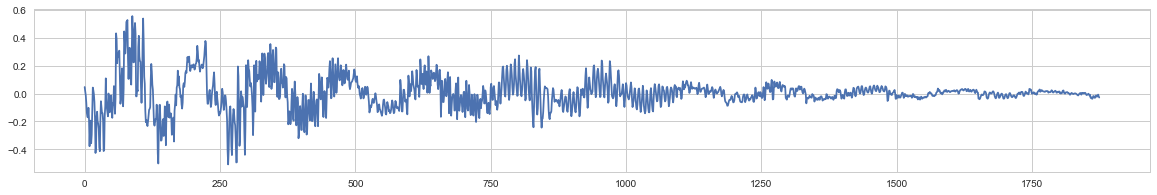

In [82]:

figsize(20,3)
audio2 = render(loadedNets[bestNetwork], patternCs,  lrMod=1.0, alphaMod=1.0, speed=0.8)
plot(audio2)
Audio(data=audio2,rate=sr)

In [85]:
import dill as pickle
model = {"net":loadedNets[bestNetwork], "Cs":patternCs, "apertures":apertures}
with open(r"models/expt1SnareModel.pickled", "wb") as output_file:    
    pickle.dump(model, output_file, protocol=0)

In [9]:
#load a saved model
import dill as pickle
with open(r"models/expt1SnareModel.pickled", "rb") as in_file:    
    model = pickle.load(in_file)

In [83]:
def conceptorAnd(C1, C2):
    return linalg.inv(linalg.inv(C1) + linalg.inv(C2) - np.eye(C1.shape[0]))

def conceptorOr(C1, C2):
    I = np.eye(C1.shape[0])
    x1 = C1.dot(linalg.inv(I - C1))
    x2 = C2.dot(linalg.inv(I - C2))
    return linalg.inv(I + linalg.inv(x1 + x2))

def conceptorNot(C1):
    return 1 - C1

In [86]:
import copy

cset = copy.deepcopy(model['Cs'])
for i in range(100):
    print(i, end=",")
    cset[i][0] = conceptorOr(conceptorOr(conceptorOr(model['Cs'][i][0], model['Cs'][(i+1) % 100][0]), model['Cs'][(i+2) % 100][0]), model['Cs'][(i+3) % 100][0])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

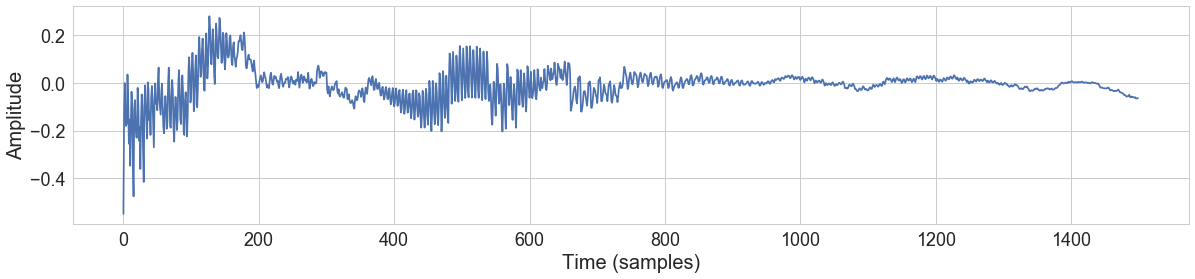

In [89]:
figsize(20,4)
audio3 = render(model['net'], cset, cMod=0.95,lrMod=1.0, alphaMod=1.0, speed=1)
plot(audio3)
plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

plt.savefig("/tmp/expt1Logic1.pdf", bbox_inches='tight')
Audio(data=audio3,rate=sr)


/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/librosa/display.py:656: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  if np.issubdtype(data.dtype, np.complex):


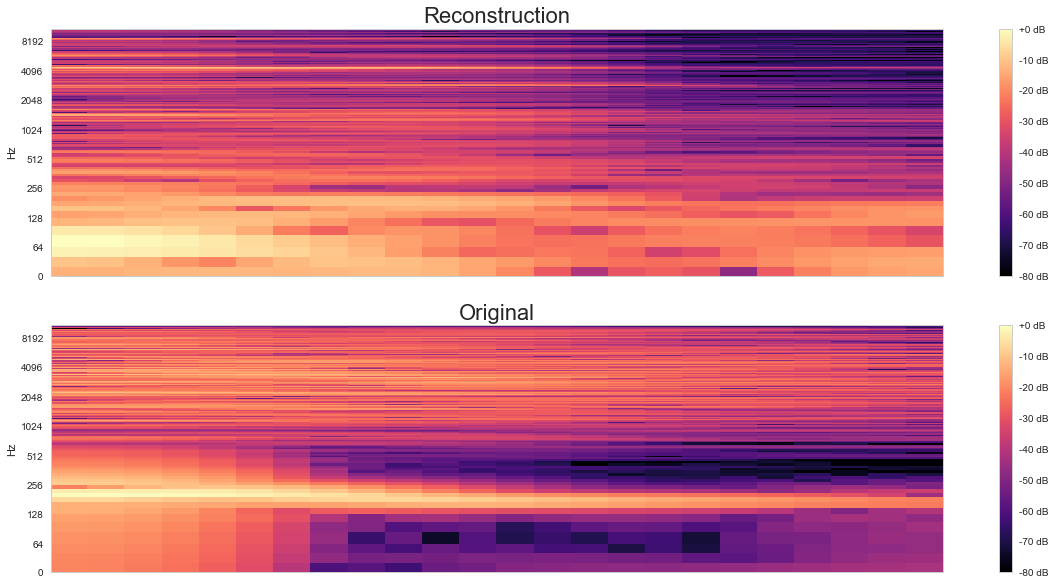

In [100]:
figsize(20,10)
import librosa.display
subplot(2,1,1)
CQT = librosa.amplitude_to_db(librosa.stft(audio3, n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Reconstruction', fontsize=22)
subplot(2,1,2)
CQT = librosa.amplitude_to_db(librosa.stft(y[:audio.shape[0]], n_fft=1024, hop_length=64), ref=np.max)
ax = librosa.display.specshow(CQT, y_axis='log', sr=22050)
plt.colorbar(format='%+2.0f dB')
ax.set_title('Original', fontsize=22)
# plt.savefig("tmp/expt1Spectra.pdf")

In [90]:
idxs=arange(model['Cs'].size)
np.random.shuffle(idxs)
idxs2=arange(model['Cs'].size)
np.random.shuffle(idxs2)


In [91]:

cset2 = copy.deepcopy(model['Cs'])
for i in range(100):
    print(i, end=",")
    cset2[i][0] = conceptorOr( conceptorOr(model['Cs'][i][0], model['Cs'][idxs[i]][0]), model['Cs'][idxs2[i]][0])

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

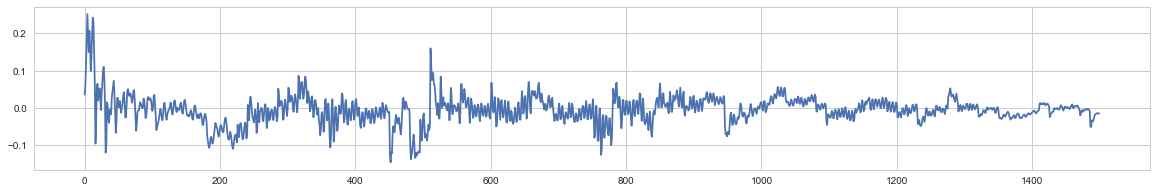

In [92]:
figsize(20,3)
audio4 = render(model['net'], cset2, cMod=0.96,lrMod=1.0, alphaMod=1.0, speed=1)
plot(audio4)
Audio(data=audio4,rate=sr)

0,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-
1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-
2,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-43-44-45-46-47-48-49-50-51-52-53-54-55-56-57-58-59-60-61-62-63-64-65-66-67-68-69-70-71-72-73-74-75-76-77-78-79-80-81-82-83-84-85-86-87-88-89-90-91-92-93-94-95-96-97-98-99-
3,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18-19-20-21-22-23-24-25-26-27-28-29-30-31-32-33-34-35-36-37-38-39-40-41-42-

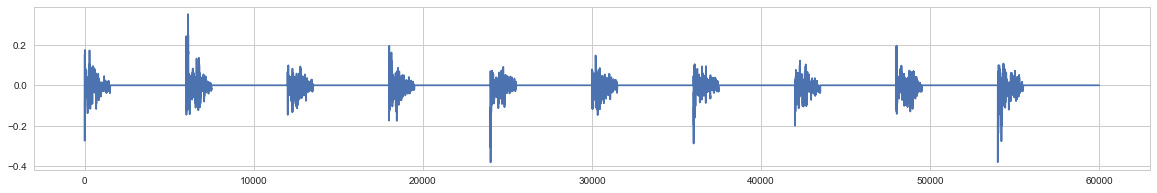

In [93]:
figsize(20,3)
testCount=10
renders = np.empty((testCount,audio.size))
recording = np.array([])
for i_sample in range(testCount):
    print(i_sample, end=",")
    idxs=arange(model['Cs'].size)
    np.random.shuffle(idxs)    
    idxs2=arange(model['Cs'].size)
    np.random.shuffle(idxs2)
    cset2 = copy.deepcopy(model['Cs'])
    for i in range(100):
        print(i, end="-")
        cset2[i][0] = conceptorOr(conceptorOr(model['Cs'][i][0], model['Cs'][idxs[i]][0]), model['Cs'][idxs2[i]][0])
        
    audio5 = render(model['net'], cset2, cMod=0.96, lrMod=1.0, alphaMod=1.0, speed=1, initScale=0.5, initOffset=0.0)
    recording = np.concatenate((recording, audio5, np.zeros(1500*3)))
    renders[i_sample] = audio5
    print("")
plot(recording)
Audio(data=recording,rate=sr)

/Volumes/LocalDataHD/virtualenvs/env3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


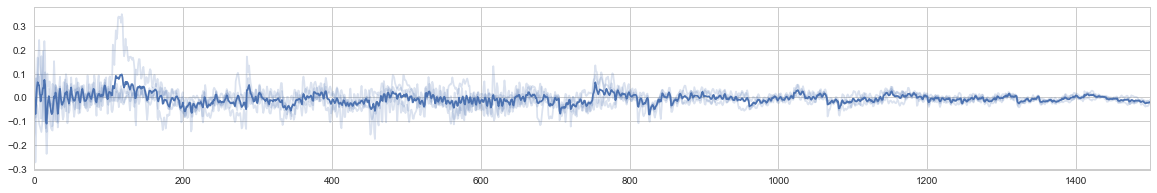

In [94]:
figsize(20,3)
sns.tsplot(renders[:4,:], err_style="unit_traces")


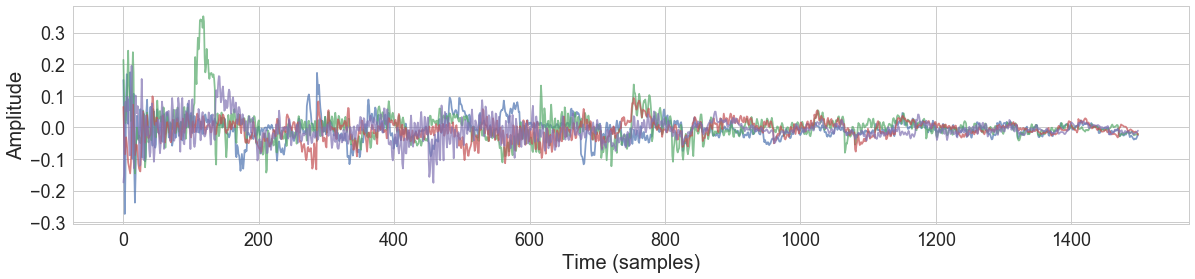

In [98]:
figsize(20,4)
plot(renders[0], alpha=0.7)
plot(renders[1], alpha=0.7)
plot(renders[2], alpha=0.7)
plot(renders[3], alpha=0.7)

plt.xlabel("Time (samples)", fontsize=20)
plt.ylabel("Amplitude", fontsize=20)
plt.xticks(fontsize=18, rotation=0)
plt.yticks(fontsize=18, rotation=0)

plt.savefig("/tmp/expt1Logic2.pdf", bbox_inches='tight')

In [526]:
cset = copy.deepcopy(model['Cs'])
Call = copy.deepcopy(cset[0][0])
for i in range(100-1):
    print(i, end=",")
    Call = conceptorOr(Call, model['Cs'][(i+1) % 100][0])

for i in range(100):
    cset[i][0] = Call

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,

0,1,2,

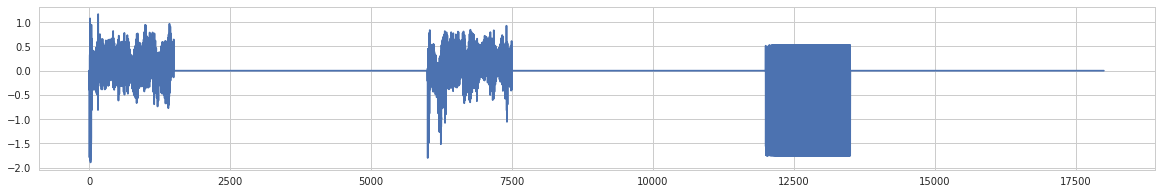

In [531]:
figsize(20,3)
testCount=3
renders = np.empty((testCount,audio.size))
recording = np.array([])
for i_sample in range(testCount):
    print(i_sample, end=",")
    audio = render(model['net'], cset, cMod=1, lrMod=1.0, alphaMod=1.0, speed=1, initScale=0.5, initOffset=0.0)
    recording = np.concatenate((recording, audio, np.zeros(1500*3)))
    renders[i_sample] = audio
plot(recording)
Audio(data=recording,rate=sr)